In [1]:
"""
Sets up the data for predicting the end token
"""

from tqdm import tqdm

from coprover.lemmaret.vectorizers import *

In [2]:
sbv = SBertVectorizer()

In [3]:
sbv.vectorize("<ANT> <CONS> s-formula apply constant apply constant constant constant <HID>").shape

(768,)

In [4]:
tokenizer = sbv.model.tokenizer

In [5]:
from transformers import (
    T5ForConditionalGeneration,
    MT5ForConditionalGeneration,
    ByT5Tokenizer,
    PreTrainedTokenizer,
    T5TokenizerFast as T5Tokenizer,
    MT5TokenizerFast as MT5Tokenizer,
)

In [6]:
tokenizer.encode("<ANT> <CONS> s-formula apply constant apply constant constant constant <HID>")

[4,
 38,
 423,
 62,
 40,
 1363,
 45,
 57,
 56,
 61,
 40,
 290,
 23,
 857,
 339,
 1983,
 390,
 418,
 1983,
 390,
 418,
 390,
 418,
 390,
 418,
 1363,
 1385,
 46,
 40,
 5]

In [7]:
# Now msuter the data
from pathlib import Path
import pandas as pd

from coprover import DATA_ROOT, RSC_ROOT

cmdpred_df = pd.read_csv(Path(RSC_ROOT, "pvs_cmd_pred", "data","cmdpred_N3.pvslib.tsv.gz"), sep='\t', names=['sequent', 'command', 'cmd_history', 'uri'])
                         

In [8]:
cmdpred_df[0:22]

,sequent,command,cmd_history,uri
0,<ANT> <CONS> s-formula forall ['variable'] ['v...,skosimp*,"NOOP,NOOP,NOOP",vect2_cont_comp-proofs/comp_rr_vr_cont#0
1,<ANT> <CONS> s-formula apply constant apply co...,typepred,"NOOP,NOOP,skosimp*",vect2_cont_comp-proofs/comp_rr_vr_cont#1
2,<ANT> s-formula apply constant apply constant ...,typepred,"NOOP,skosimp*,typepred",vect2_cont_comp-proofs/comp_rr_vr_cont#2
3,<ANT> s-formula apply constant apply constant ...,expand,"skosimp*,typepred,typepred",vect2_cont_comp-proofs/comp_rr_vr_cont#3
4,<ANT> s-formula apply constant apply constant ...,expand,"typepred,typepred,expand",vect2_cont_comp-proofs/comp_rr_vr_cont#4
5,<ANT> s-formula apply constant forall ['variab...,skosimp*,"typepred,expand,expand",vect2_cont_comp-proofs/comp_rr_vr_cont#5
6,<ANT> s-formula apply constant forall ['variab...,expand,"expand,expand,skosimp*",vect2_cont_comp-proofs/comp_rr_vr_cont#6
7,<ANT> s-formula apply constant forall ['variab...,inst,"expand,skosimp*,expand",vect2_cont_comp-proofs/comp_rr_vr_cont#7
8,<ANT> s-formula apply constant apply constant ...,inst,"skosimp*,expand,inst",vect2_cont_comp-proofs/comp_rr_vr_cont#8
9,<ANT> s-formula apply constant apply constant ...,expand,"expand,inst,inst",vect2_cont_comp-proofs/comp_rr_vr_cont#9


In [9]:
# Identify proofs by name
start_state = None
last_state = None
last_proofname = None

def get_proofname(uri):
    return uri.split('#', 1)[0]


proofnames = [get_proofname(row.uri) for idx, row in cmdpred_df.iterrows()]
cmdpred_df['proofname'] = proofnames
grp_obj = cmdpred_df.groupby('proofname')
proofnames = list(grp_obj.groups.keys())
print(f"Total unique proofs={len(proofnames)}")

Total unique proofs=7656


In [10]:
# Identify lengths of proofs
proof_lengths = []
for proofname in tqdm(proofnames):
    rows = grp_obj.get_group(proofname)
    proof_lengths.append(len(rows))

from collections import Counter
from pprint import pprint
print("Histogram of proof lengths")
pprint(Counter(proof_lengths))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7656/7656 [00:00<00:00, 8545.19it/s]


Histogram of proof lengths
Counter({1: 994,
         5: 503,
         2: 445,
         6: 417,
         4: 400,
         7: 323,
         3: 315,
         8: 299,
         9: 291,
         10: 230,
         11: 214,
         12: 180,
         14: 164,
         13: 163,
         15: 137,
         18: 107,
         19: 103,
         17: 100,
         22: 99,
         21: 98,
         16: 96,
         26: 82,
         20: 80,
         23: 67,
         34: 67,
         24: 66,
         25: 60,
         27: 55,
         29: 54,
         33: 52,
         32: 52,
         30: 50,
         38: 48,
         35: 45,
         28: 43,
         39: 41,
         43: 39,
         41: 38,
         31: 35,
         36: 30,
         37: 27,
         45: 24,
         40: 24,
         53: 23,
         55: 23,
         42: 23,
         48: 21,
         57: 20,
         58: 18,
         49: 16,
         61: 15,
         47: 15,
         44: 15,
         46: 14,
         51: 14,
         50: 14,
         62:

In [15]:
PROOFNAME = "proofname"
STATE = "source_text"
LABEL = "target_text"
POS = "pos{:02d}"  # Formatted label for number of steps to end
NEG = "neg"
CMD_HISTORY = "cmd_history"

class MTuple:
    def __init__(self, proofname, start_row, curr_row, label):
        self.proofname = proofname
        self.label = label
        self.start_row, self.curr_row = start_row, curr_row
        self.cmd_history = self.curr_row.cmd_history
        assert str(self.start_row) != str(self.curr_row)

    def __str__(self, str):
        return self.proofname
    
    def _statestr(self):
        cmdhist_str = self.curr_row.cmd_history.replace(",", " ")
        return "{} {} {}".format(cmdhist_str, self.start_row.sequent, self.curr_row.sequent)  # First naive formulation
    
    def as_row(self):
        return {
            PROOFNAME: self.proofname,
            STATE: self._statestr(),
            CMD_HISTORY: self.curr_row.cmd_history.replace(",", " "),
            LABEL: self.label
        }

In [21]:
from random import Random

rnd = Random()
rnd.seed(1337)

pos_mtuples = []
neg_mtuples = []
hard_neg_mtuples = []

N_END = 2 # Up to 2 from end
NUM_NEGATIVES = N_END + 1 
for proofname in tqdm(proofnames):
    rows = grp_obj.get_group(proofname)
    if len(rows) >= (2 + N_END + 1):  # Enough for separate start and end, with padding, and a hard negative
        start_row = rows.iloc[0]
        for n_idx in range(0, N_END + 1):
            curr_row = rows.iloc[ len(rows) - (n_idx + 1)]
            label = POS.format(n_idx)
            pos_mtuples.append(MTuple(proofname, start_row, curr_row, label))
        hard_neg_row = rows.iloc[len(rows) - (N_END + 1)]  # Hard negative, the one right before
        hard_neg_mtuples.append(MTuple(proofname, start_row, hard_neg_row, NEG))
        # Sample N negatives
        for _ in range(NUM_NEGATIVES):
            random_neg_row = rows.iloc[rnd.randint(1, len(rows) - N_END)]
            neg_mtuples.append(MTuple(proofname, start_row, random_neg_row, NEG))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7656/7656 [00:30<00:00, 248.22it/s]


In [22]:
idx=0
print("Start")
print(pos_mtuples[idx].start_row.sequent, pos_mtuples[idx].start_row.cmd_history)
print("\n\nPositive")
print(pos_mtuples[idx].curr_row.sequent, pos_mtuples[idx].curr_row.cmd_history)

print("\n\nNegative")
print(neg_mtuples[idx].curr_row.sequent, neg_mtuples[idx].curr_row.cmd_history)

print("\n\nHard Negative")
print(hard_neg_mtuples[idx].curr_row.sequent, hard_neg_mtuples[idx].curr_row.cmd_history)


Start
<ANT> <CONS> s-formula forall ['variable'] ['variable'] ['variable'] apply constant apply constant apply constant ['variable'] apply constant ['variable'] apply constant ['variable'] ['variable'] apply constant apply constant ['variable'] ['variable'] apply constant ['variable'] ['variable'] <HID>  NOOP,NOOP,NOOP


Positive
<ANT> s-formula apply constant apply constant type-actual apply constant integer constant apply constant constant apply constant apply constant constant constant apply constant constant constant s-formula apply constant apply constant type-actual apply constant constant constant integer s-formula apply constant forall ['variable'] apply constant apply constant apply constant type-actual ['variable'] integer apply constant type-actual ['variable'] constant apply constant apply constant ['variable'] constant s-formula apply constant apply constant constant integer s-formula apply constant apply constant type-actual apply constant constant constant apply constant

In [23]:
# save as a dataframe and then feed into simple_t5
# setup so only tuples below max token lengths can be used

filtered_rows = []
total = 0
for mt in pos_mtuples + neg_mtuples:
    entry = mt.as_row()
    total += 1
    if len(entry[STATE].split()) <= 1000:
        filtered_rows.append(entry)

print("Filtered size={}/{}".format(len(filtered_rows), total))
inst_df = pd.DataFrame(filtered_rows)
inst_df.to_csv("laststep_pred.v2.csv.gz", header=True)

Filtered size=32890/33012


In [24]:
inst_df

,proofname,source_text,cmd_history,target_text
0,.ipynb_checkpoints/Euclids_30-checkpoint,factor expand inst <ANT> <CONS> s-formula fora...,factor expand inst,pos00
1,.ipynb_checkpoints/Euclids_30-checkpoint,simplify factor expand <ANT> <CONS> s-formula ...,simplify factor expand,pos01
2,.ipynb_checkpoints/Euclids_30-checkpoint,replace simplify factor <ANT> <CONS> s-formula...,replace simplify factor,pos02
3,.ipynb_checkpoints/all_least_bounded-checkpoint,flatten-disjunct flatten instantiate <ANT> <CO...,flatten-disjunct flatten instantiate,pos00
4,.ipynb_checkpoints/all_least_bounded-checkpoint,expand flatten-disjunct flatten <ANT> <CONS> s...,expand flatten-disjunct flatten,pos01
...,...,...,...,...
32885,zp_group-proofs/Zn_card,hide inst expand <ANT> <CONS> s-formula apply ...,hide inst expand,neg
32886,zp_group-proofs/Zn_card,instantiate inst? expand <ANT> <CONS> s-formul...,instantiate inst? expand,neg
32887,zp_group-proofs/Zn_group,split prop expand <ANT> <CONS> s-formula apply...,split prop expand,neg
32888,zp_group-proofs/Zn_group,skolem skolem! skosimp <ANT> <CONS> s-formula ...,skolem skolem! skosimp,neg


<AxesSubplot:>

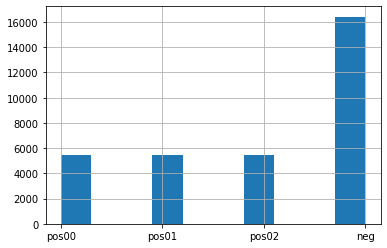

In [26]:
inst_df['target_text'].hist()